<img src="https://www.fda.gov/files/Coronavirus_3D_illustration_by_CDC_1600x900.png">

# 🦠 COVID-19 Forecasting using LSTM and Facebook Prophet

COVID-19 struck the world starting early 2020. Daily report of new active cases are always on the news and it continuously adding up. In this notebook we will use Long-Short Term Memory neural networks and Facebook Prophet to forecast global confirmed cases daily.

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
## For Lstm
from tensorflow.keras import models, layers, preprocessing as kprocessing
## For Prophet
from fbprophet import Prophet
from sklearn import preprocessing
from keras.preprocessing.sequence import TimeseriesGenerator

import plotly.graph_objs as go

# Initialize dataset

In [2]:
df=pd.read_csv('../input/covid-19-global-reports-early-march-2022/covid_19_clean_complete_2022.csv')
df.drop(columns ='Province/State', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df_uni=df.groupby(['Date'])['Confirmed','Deaths','Recovered','Active'].sum()
df_uni.isnull().sum()
df_uni.drop(columns ='Deaths', inplace = True)
df_uni.drop(columns ='Recovered', inplace = True)
df_uni.drop(columns ='Active', inplace = True)
df_uni['Confirmed'] = df_uni['Confirmed'].astype(float)
df_uni2 = df_uni.head(220)
df_uni = df_uni.head(188)
df_uni.head()

,Confirmed
Date,
2020-01-22,557.0
2020-01-23,657.0
2020-01-24,944.0
2020-01-25,1437.0
2020-01-26,2120.0


In [3]:
ts = df_uni.groupby("Date")["Confirmed"].sum().rename("cases")
ts.head()

Date
2020-01-22     557.0
2020-01-23     657.0
2020-01-24     944.0
2020-01-25    1437.0
2020-01-26    2120.0
Name: cases, dtype: float64

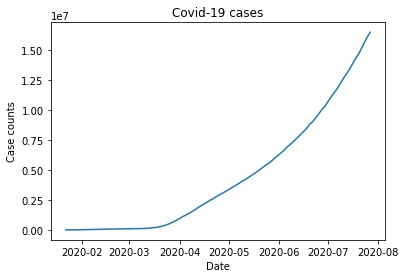

In [4]:
dates = df_uni.index.values
counts = df_uni['Confirmed'].to_numpy()
timeseries_data = { 
    'Date': dates, 
    
    'Confirmed': counts
}

plt.plot(df_uni)

# Labelling 

plt.xlabel("Date")
plt.ylabel("Case counts")
plt.title("Covid-19 cases")

# Display

plt.show()

# Pre-processing

In [5]:
def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ 
                      ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
        
    return ts_train, ts_test

Evaluation Metric Function

In [6]:
'''
Evaluation metrics for predictions.
:parameter
    :param dtf: DataFrame with columns raw values, fitted training  
                 values, predicted test values
:return
    dataframe with raw ts and forecast
'''
def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

Pre-processing functions

In [7]:
'''
Preprocess a ts partitioning into X and y.
:parameter
    :param ts: pandas timeseries
    :param s: num - number of observations per seasonal (ex. 7 for weekly seasonality with daily data, 12 for yearly seasonality with monthly data)
    :param scaler: sklearn scaler object - if None is fitted
    :param exog: pandas dataframe or numpy array
:return
    X, y, scaler
'''
def utils_preprocess_ts(ts, s, scaler=None, exog=None):
    ## scale
    if scaler is None:
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    ts_preprocessed = scaler.fit_transform(ts.values.reshape(-1,1)).reshape(-1)        

    ## create X,y for train
    #ts_preprocessed = kprocessing.sequence.TimeseriesGenerator(data=ts_preprocessed, targets=ts_preprocessed, length=s, batch_size=1)
    ts_preprocessed = TimeseriesGenerator(data=ts_preprocessed, targets=ts_preprocessed, length=s, batch_size=1)

    lst_X, lst_y = [], []
    for i in range(len(ts_preprocessed)):
        xi, yi = ts_preprocessed[i]
        lst_X.append(xi)
        lst_y.append(yi)
    X = np.array(lst_X)
    y = np.array(lst_y)
    return X, y, scaler
'''
Get fitted values.
'''
def utils_fitted_lstm(ts, model, scaler, exog=None):
    ## scale
    ts_preprocessed = scaler.fit_transform(ts.values.reshape(-1,1)).reshape(-1) 
    
    ## create Xy, predict = fitted
    s = model.input_shape[-1]
    lst_fitted = [np.nan]*s
    for i in range(len(ts_preprocessed)):
        end_ix = i + s
        if end_ix > len(ts_preprocessed)-1:
            break
        X = ts_preprocessed[i:end_ix]
        X = np.array(X)
        X = np.reshape(X, (1,1,X.shape[0]))
        fit = model.predict(X)
        fit = scaler.inverse_transform(fit)[0][0]
        lst_fitted.append(fit)
    return np.array(lst_fitted)
'''
Predict ts using previous predictions.
'''
def utils_predict_lstm(ts, model, scaler, pred_ahead, exog=None):
    ## scale
    s = model.input_shape[-1]
    ts_preprocessed = list(scaler.fit_transform(ts[-s:].values.reshape(-1,1))) 
    ## predict, append, re-predict
    lst_preds = []
    for i in range(pred_ahead):
        X = np.array(ts_preprocessed[len(ts_preprocessed)-s:])
        X = np.reshape(X, (1,1,X.shape[0]))
        X = X.astype(np.float)
        #print(type(X))
        pred = model.predict(X)
        ts_preprocessed.append(pred)
        pred = scaler.inverse_transform(pred)[0][0]
        lst_preds.append(pred)
    return np.array(lst_preds)

'''
Generate dates to index predictions.
:parameter
    :param start: str - "yyyy-mm-dd"
    :param end: str - "yyyy-mm-dd"
    :param n: num - length of index
    :param freq: None or str - 'B' business day, 'D' daily, 'W' 
                 weekly, 'M' monthly, 'A' annual, 'Q' quarterly
'''
def utils_generate_indexdate(start, end=None, n=None, freq="D"):
    if end is not None:
        index = pd.date_range(start=start, end=end, freq=freq)
    else:
        index = pd.date_range(start=start, periods=n, freq=freq)
    index = index[1:]
    print("--- generating index date --> start:", index[0], "| end:", index[-1], "| len:", len(index), "---")
    return index

Splitting the data

In [8]:
ts_train, ts_test = split_train_test(ts)

--- splitting at index:  150 | 2020-06-20 00:00:00 | test size: 0.2  ---


In [9]:
dtf_train = ts_train.reset_index().rename(columns={"Date":"ds", "cases":"y"})
dtf_test = ts_test.reset_index().rename(columns={"Date":"ds", "cases":"y"})
dtf_test.tail()
dtf_train.head()

,ds,y
0,2020-01-22,557.0
1,2020-01-23,657.0
2,2020-01-24,944.0
3,2020-01-25,1437.0
4,2020-01-26,2120.0


# LSTM

In [10]:
## Keras models
model = models.Sequential()
model.add( layers.LSTM(input_shape=(1,3), units=50, 
           activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.add( layers.Dropout(0.2) )
model.compile(optimizer='adam', loss='mean_absolute_error')

2022-06-17 07:47:14.979505: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Fitting and Training

In [11]:
'''
Fit Long short-term memory neural network.
:parameter
    :param ts: pandas timeseries
    :param exog: pandas dataframe or numpy array
    :param s: num - number of observations per seasonal (ex. 7 for weekly seasonality with daily data, 12 for yearly seasonality with monthly data)
:return
    generator, scaler 
'''
def fit_lstm(ts_train, ts_test, model, exog=None, s=20, 
             figsize=(15,5)):
    ## check
    print("Seasonality: using the last", s, "observations to predict the next 1")
    
    ## preprocess train
    X_train, y_train, scaler = utils_preprocess_ts(ts_train, scaler=None, exog=exog, s=s)
    
    ## lstm
    if model is None:
        model = models.Sequential()
        model.add( layers.LSTM(input_shape=X_train.shape[1:], units=50, activation='relu', return_sequences=False) )
        model.add( layers.Dense(1) )
        model.compile(optimizer='adam', loss='mean_absolute_error')
    
    ## train
    print(model.summary())
    training = model.fit(x=X_train, y=y_train, batch_size=1, epochs=100, shuffle=True, verbose=0, validation_split=0.3)
    
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = utils_fitted_lstm(ts_train, training.model, 
                                           scaler, exog)
    dtf_train["model"] = dtf_train["model"].fillna(method='bfill')
    
    ## test
    preds = utils_predict_lstm(ts_train[-s:], training.model, scaler, pred_ahead=len(ts_test), exog=None)
    dtf_test = ts_test.to_frame(name="ts").merge(
                       pd.DataFrame(data=preds, index=ts_test.index, 
                                    columns=["forecast"]),
               how='left', left_index=True, right_index=True)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, 
                                  title="LSTM (memory:"+str(s)+")")
    return dtf, training.model

Seasonality: using the last 3 observations to predict the next 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________
None


2022-06-17 07:47:15.510031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


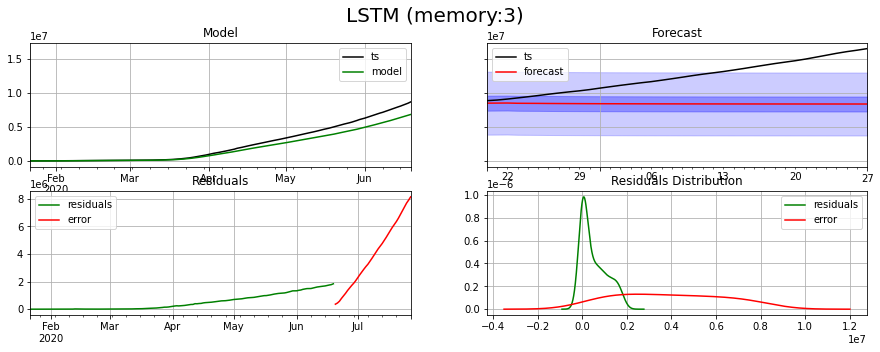

Training --> Residuals mean: 505993.0  | std: 562022.0
Test --> Error mean: 3947000.0  | std: 2360439.0  | mae: 3947000.0  | mape: 30.0 %  | mse: 21003856462871.0  | rmse: 4582996.0


In [12]:
dtf, model = fit_lstm(ts_train, ts_test, model, s=3)

# Prophet

In [13]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, 
                seasonality_mode="multiplicative", yearly_seasonality="auto", 
                weekly_seasonality="auto", daily_seasonality=False, holidays=None)

Fitting and Training

In [14]:
'''
Fits prophet on Business Data:
    y = trend + seasonality + holidays
:parameter
    :param dtf_train: pandas Dataframe with columns 'ds' (dates), 
             'y' (values), 'cap' (capacity if growth="logistic"), 
             other additional regressor
    :param dtf_test: pandas Dataframe with columns 'ds' (dates), 'y' 
                     (values), 'cap' (capacity if 
                      growth="logistic"), 
                      other additional regressor
    :param lst_exog: list - names of variables
    :param freq: str - "D" daily, "M" monthly, "Y" annual, "MS" 
                       monthly start ...
:return
    dtf with predictons and the model
'''
def fit_prophet(dtf_train, dtf_test, lst_exog=None, model=None, 
                freq="D", figsize=(15,10)):
    ## train
    model.fit(dtf_train)
    
    ## test
    dtf_prophet = model.make_future_dataframe(periods=len(dtf_test), 
                  freq=freq, include_history=True)
    dtf_prophet = model.predict(dtf_prophet)
    dtf_train = dtf_train.merge(dtf_prophet[["ds","yhat"]], 
                how="left").rename(columns={'yhat':'model', 
                'y':'ts'}).set_index("ds")
    dtf_test = dtf_test.merge(dtf_prophet[["ds","yhat"]], 
                how="left").rename(columns={'yhat':'forecast',  
                'y':'ts'}).set_index("ds")
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, 
                                  title="Prophet")
    return dtf, model

Initial log joint probability = -6.61273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       654.258      0.040331       1490.97      0.8509      0.8509      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       707.397    0.00986474       1463.73           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       723.912     0.0248464       2562.77           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       734.901   0.000800299       579.736           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       738.378    0.00179763       507.723           1           1      600   
    Iter      log prob        ||dx||      ||grad||       alpha  

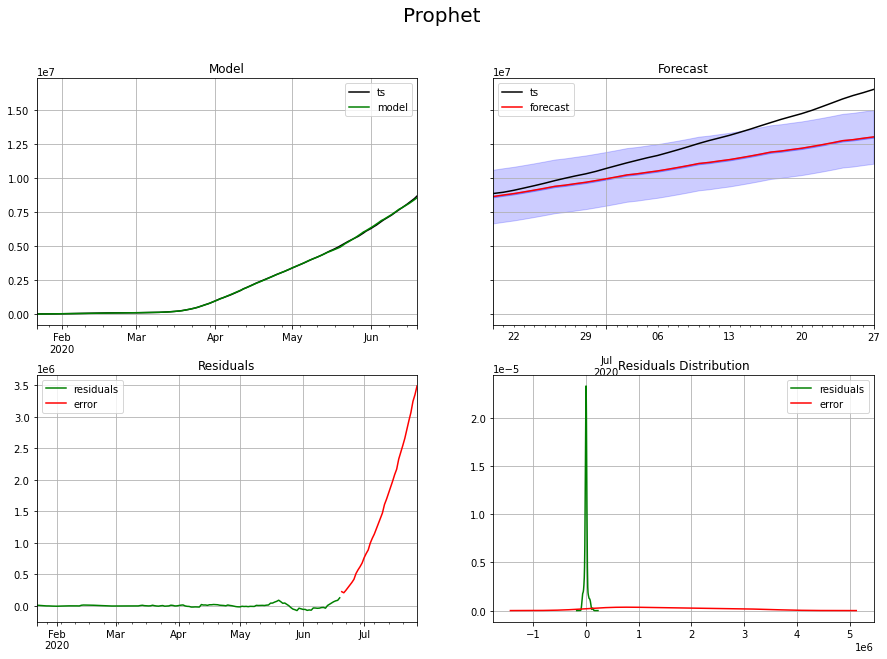

Training --> Residuals mean: -2.0  | std: 28321.0
Test --> Error mean: 1513532.0  | std: 1005241.0  | mae: 1513532.0  | mape: 11.0 %  | mse: 3274696922295.0  | rmse: 1809612.0


In [15]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D")

# Forecasting

In [16]:
'''
Plot unknown future forecast.
'''
def utils_plot_forecast(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf[["ts","forecast"]].plot(color=["black","red"], grid=True, ax=ax[0], title="History + Future")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3) 
          
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:][["ts","forecast"]].plot(color=["black","red"], grid=True, ax=ax[1], title="Zoom on the last "+str(zoom)+" observations")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [17]:
'''
Forecast unknown future.
'''
def forecast_lstm(ts, model, pred_ahead=None, end=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    s = model.input_shape[-1]

    X, y, scaler = utils_preprocess_ts(ts, scaler=None, exog=None, s=s)
    training = model.fit(x=X, y=y, batch_size=1, epochs=90, shuffle=True, verbose=0, validation_split=0.2)

    dtf = ts.to_frame(name="ts")
    dtf["model"] = utils_fitted_lstm(ts, training.model, scaler, None)
    dtf["model"] = dtf["model"].fillna(method='bfill')
    
    ## index
    #index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)

    ## forecast
    preds = utils_predict_lstm(ts[-s:], training.model, scaler, pred_ahead=len(index), exog=None)
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    dtf = utils_plot_forecast(dtf, zoom=zoom)
    return dtf
'''
Forecast unknown future.
'''
def forecast_prophet(dtf, model, pred_ahead=None, end=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    model.fit(dtf)
    
    ## index
    index = utils_generate_indexdate(start=dtf["ds"].values[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    dtf_prophet = model.make_future_dataframe(periods=len(index), freq=freq, include_history=True)
    dtf_prophet = model.predict(dtf_prophet)
    dtf = dtf.merge(dtf_prophet[["ds","yhat"]], how="left").rename(columns={'yhat':'model', 'y':'ts'}).set_index("ds")
    preds = pd.DataFrame(data=index, columns=["ds"])
    preds = preds.merge(dtf_prophet[["ds","yhat"]], how="left").rename(columns={'yhat':'forecast'}).set_index("ds")
    dtf = dtf.append(preds)
    
    ## plot
    dtf = utils_plot_forecast(dtf, zoom=zoom)
    return dtf

LSTM Forecast

--- generating index date --> start: 2020-07-28 00:00:00 | end: 2020-08-27 00:00:00 | len: 31 ---


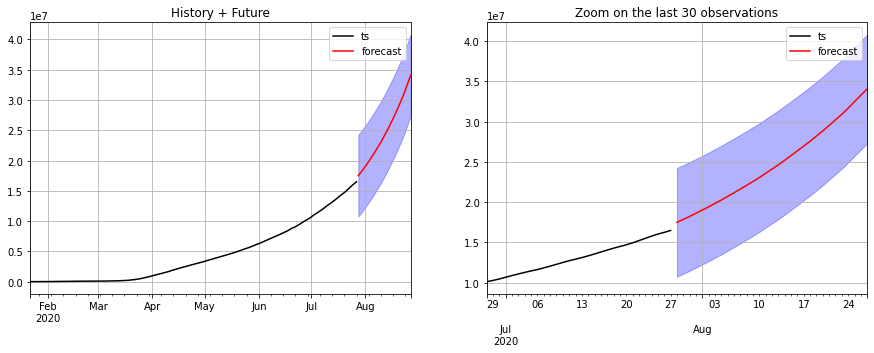

In [18]:
model = models.Sequential()
model.add(layers.LSTM(input_shape=(1,150), units=50, activation='relu', return_sequences=False))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')
lstm_future = forecast_lstm(ts, model, end="2020-08-27")
#lstm_future['forecast']

Prophet Forecast

Initial log joint probability = -8.12167
--- generating index date --> start: 2020-07-28 00:00:00 | end: 2020-08-27 00:00:00 | len: 31 ---
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        733.37    0.00661807       806.108           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       810.216    0.00396834       950.953           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       838.988    0.00220166       603.787      0.2867           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        861.59    0.00379308       2035.72      0.3433           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       871.246    0.00138743        297.22   

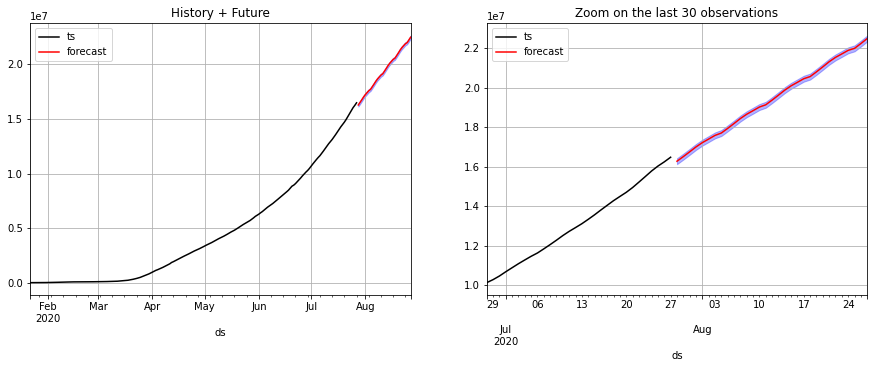

In [19]:
model = Prophet(growth="linear", changepoints=None, 
                n_changepoints=25, 
                seasonality_mode="multiplicative",
                yearly_seasonality="auto", 
                weekly_seasonality="auto", daily_seasonality=True,
                holidays=None)
dfpr = ts.reset_index().rename(columns={"Date":"ds", 
                                                   "cases":"y"})
prophet_future = forecast_prophet(dfpr, model, end="2020-08-27")
prophet_future['forecast'] = prophet_future['forecast'].astype('float32')
#prophet_future['forecast']

In [20]:
pr_df = prophet_future['forecast'].to_frame()
lstm_df = lstm_future['forecast'].to_frame()

lstm_df = lstm_df.tail(31)
pr_df = pr_df.tail(31)

In [21]:
lstm_df.describe()

,forecast
count,31.0
mean,24687254.0
std,4978128.5
min,17500570.0
25%,20485910.0
50%,24101620.0
75%,28519041.0
max,34055764.0


In [22]:
pr_df.describe()

,forecast
count,31.0
mean,19422128.0
std,1863403.0
min,16281563.0
25%,17827698.0
50%,19376298.0
75%,20933533.0
max,22494026.0


# Forecast Comparison

In [23]:
y_data = df_uni2.values
y_data = y_data.reshape((-1,1))
#y_data
split_percent = 0.80
split = len(y_data) - 32
print(split)
y_train = y_data[:split]
y_test = y_data[split:]

date_train = df_uni2.index.values[:split]
date_test = df_uni2.index.values[split:]

y_train = y_train.reshape((-1))
y_test = y_test.reshape((-1))

pr = prophet_future['forecast'].tail(31).values
ls = lstm_future['forecast'].tail(31).values

trace1 = go.Scatter(
    x = date_train,
    y = y_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = pr,
    mode = 'lines',
    name = 'Prophet'
)
trace3 = go.Scatter(
    x = date_test,
    y = y_test,
    mode='lines',
    name = 'Actual'
)
trace4 = go.Scatter(
    x = date_test,
    y = ls,
    mode = 'lines',
    name = 'LSTM'
)
layout = go.Layout(
    title = "Covid-19 cases",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Confirmed"}
)
fig = go.Figure(data=[trace1, trace2, trace4, trace3], layout=layout)
fig.show()

188
